# Access and Explore Data - Synthetic
Ben Lasscock, Enthought

blasscock@enthought.com

In addition to the Ichthys3D seismic data, the [2020 FORCE Machine Learning Contest](https://xeek.ai/challenges/force-seismic/overview) provides two synthetic data, one from Equinor and one from Schlumberger. Synthetics are useful because they unambigously provide a "ground truth", i.e. by construction a complex of faults is encoded in the data, 
and so the performance of a predictive algorithm can be objectively measured. Keep in mind however, the work of 
seismic interpretation is subjective and the results of the competition will be judge subjectively; so there's a 
risk of using synthetic data alone. Second, that the character of the synthetic might be different to the real data in ways that may confound methods that rely solely on statistics, for which a convoltional neural network (cited by in the challenge website) is one such method.


In this notebook we load the Equinor synthetic data (a series of inlines). The synthetics include three sets of data in segy format; "issap20_Fault", "issap20_Pp" and the "issap20_AI" data. The data is laid out as a sequence of 2-d lines, the "inline" number changes, the "cross-line" number doesn't, so we're only going to have "inline" data in our ZArr. 

* **issap20_Fault** - This is a label of fault/not fault (1/0).
* **issap20_Pp** - "The seismic"; the "Pp" likely refers to P-wave (acoustic) energy being injected and P-wave reflections off the impedance contrasts. Sound traveling in the earth can also manifest shear-wave displacement, either from the injected source or through conversion at a reflector, hence the P rather than S. However, while the theory of sound propagating in the earth is interesting, this aspect of it doesn't seem relevant to the competition.  
* **issap20_AI** - I was excited I thought Equinor had given us this "AI" everyone is talking about, but actually this is the other AI, acoustic impedence. It's good to have this data because we might want to create new synthetics with different wavelets, different bandwidths etc as a way to augment our classifier, help it generalize a bit better. 

Our data exploration is going to two things, first we will load and render the data, with fault labels overlaid. The we will derive some metrics to qualitatively compare the character of the synthetic data to that of the Ichthys3D. The ideas we explore may also be of use if a person wants to try and "augment" their training data to help statistical models generalize.

* **Background Theory**  Acoustic energy driven by some seismic source is reflected when it encounters an impedance contrast in the earth. This reflected energy is measured over an array of sensors (geophones), and then, though a process of "migration" a map of the subsurface is created (the seismic). In practice, "seismic sources" e.g. air guns, dynamite, or vibroseis inject a broadband signal into the earth. But, because sound travelling in the earth is attenuated selectively by frequency, the shape of the wave-packet or wavelet changes, as does the frequency content of the migrated data. The shape of the wavelet may also be transformed through steps involved in the processing raw seismic data. For "time migrated data", which the Ichthys3D is, the shape of this wavelet is assumed to be stationary over the range of the data. 

* **Statistical Wavelet Extraction**  A simple model of reflection seismic data is as a seismic wavelet convolved with a sequence of impedance contrasts. If we had the model of the impedance contrast we could compute the wavelet through regression, however doing this on Ichthys3D would involve using well-logs and becomes complicated quite rapidly. If we assume the wavelet is symmetric (which it doesn't have to be), we can instead extract a "statistical wavelet" by computing the autocorrelation of the seismic data, which is what we do. The "statistical wavelet" is computed for the Ichthys3D and the synthetic data. 

 * **Augmentation Ideas** We take a statistical wavelet from Ichthys and create a new synthetic using the acoustic impedance **issap20_AI**. This could be repeated for wavelets with different bandwidth and also phase. We show how to phase rotate the statistical wavelet using a hilbert transform, which will also change the character of the seismic. 

* **Bandwidth** We compare the bandwith between real/synthetic. Can be changed by changing out the wavelet (above).

* **Distribution of reflectors** We expect the reflectivity of the earth should be "heavy tailed" i.e. there should be relatively many large reflectors. We discuss this idea in various contexts in this paper [A novel prestack sparse azimuthal AVO inversion](https://arxiv.org/abs/1710.04104). How the reflectors are organized in time is another issue to consider, qualitatively, the synthetics don't seem to have the same texture as the real data. Simulating  depositional processes and reflecting those processing in a synthetic data is a hard problem.

 * **Augmentation Ideas** Resample the impedance constrasts derived from **issap20_AI** and convolve with the wavelet for additional synthetic data. 


## Conclusions

We explored the data syntheic data with comparison to the real data and testing out ideas. The good news is that we have the data loaded and read to use through our ZArr repos which you can access. However, at least qualitatively the synethetics and real data seem to be very different in terms of bandwidth, the wavelet, and the distribution of the reflectivity. Although I don't know if this will be an issue of training models to generalize from the synthetic to the real data, we can reuse some of these ideas around wavelets, phase and reflectivity to augment the Equinor synthetic training set if needed. 




In [1]:
from matplotlib import rc
import matplotlib.pylab as plt
import numpy as np
import s3fs
from scipy.ndimage import gaussian_filter
from scipy.signal import hilbert, morlet
import seaborn as sns
import zarr

# Big Fonts!
font = {'family' : 'normal',
        'size'   : 18}
rc('font', **font)

Load the data!

We have four datasets, three from the synthetic and the real Ichthys data.

In [2]:
def open_zarr(remote_path):
    # complicated stuff to access the data
    client = s3fs.S3FileSystem(anon=True)
    store = s3fs.S3Map(
        root=remote_path,
        s3=client, 
        check=False)
    cache = zarr.LRUStoreCache(store, max_size=2**28)
    return zarr.open_group(store=cache, mode='r')

# These are the ground truth faults
fault_path='s3://zarr-depot/seismic/FaultSynthetic/issap20_Fault'
fault_data = open_zarr(fault_path)

# These are the ground truth faults
seismic_path='s3://zarr-depot/seismic/FaultSynthetic/issap20_Pp'
seismic_data = open_zarr(seismic_path)

# The other AI - Acoustic Impedence
ai_path='s3://zarr-depot/seismic/FaultSynthetic/issap20_AI'
ai_data = open_zarr(ai_path)

# contains the seqy data for Ichthys3D
real_path='s3://zarr-depot/seismic/Ichthys3D/Ichthys 3D seismic for fault competition'
real_data = open_zarr(real_path)

QC the line ranges are the same.

In [3]:
print ("inline range : ", fault_data['inlines'][:].min(), fault_data['inlines'][:].max())
print ("inline range : ", seismic_data['inlines'][:].min(), seismic_data['inlines'][:].max())
print ("inline range : ", ai_data['inlines'][:].min(), ai_data['inlines'][:].max())

inline range :  1 101
inline range :  1 101
inline range :  1 101


Visualize the seismic and AI with overlay from the seismic. Equinor provides a powerpoint with some slides for QC

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


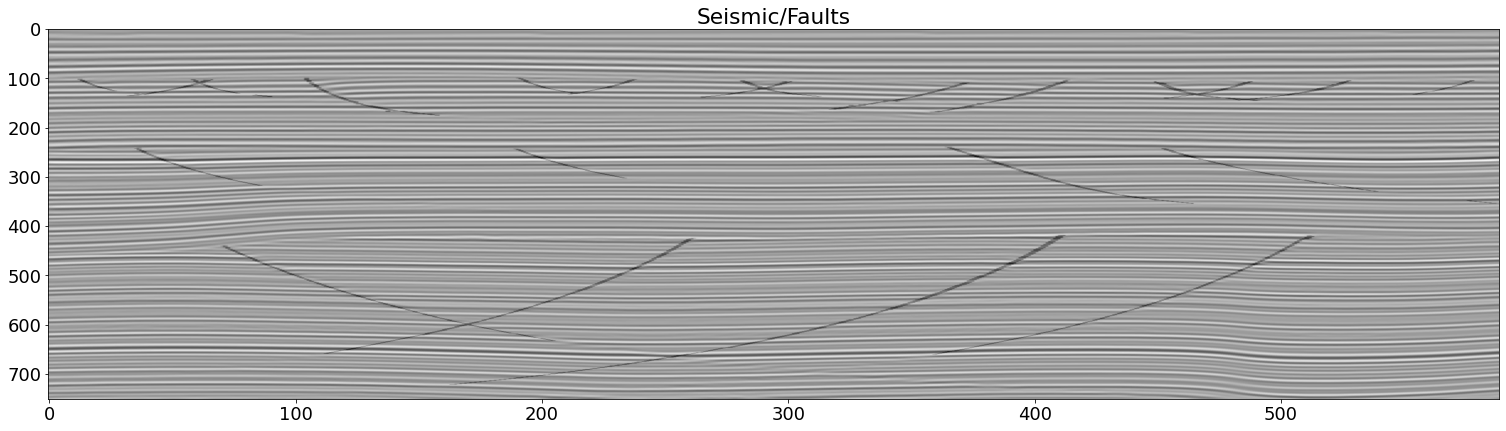

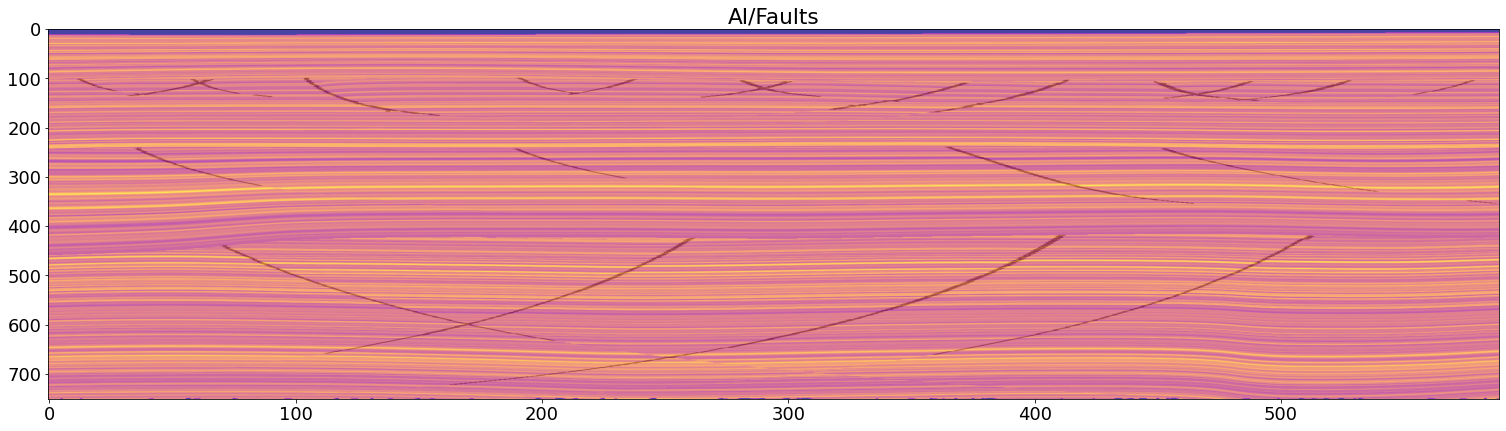

In [4]:
def clip(img):
    """Standardize contrast"""
    img = img - np.mean(img)
    return img/np.std(img)

# These are 8-bit unsigned ints
plt.figure(figsize=(26,13))
plt.imshow(seismic_data['inline'][...,10].T, cmap='gray', aspect=0.2)
plt.imshow(fault_data['inline'][...,10].T, cmap='binary', aspect=0.2, alpha=0.25)
plt.title("Seismic/Faults")
plt.show()

# These are 8-bit unsigned ints
plt.figure(figsize=(26,13))
plt.imshow(ai_data['inline'][...,10].T, cmap='plasma', aspect=0.2)
plt.imshow(fault_data['inline'][...,10].T, cmap='binary', aspect=0.2, alpha=0.25)
plt.title("AI/Faults")
plt.show()

I didn't provide the 32-bit float data for Ichthys, but the syntheics are small so I do. 
Here we just compare the seismic wavelet for the compressed versus original precision versions.
Also demonstrates how to compute a statistical wavelet.

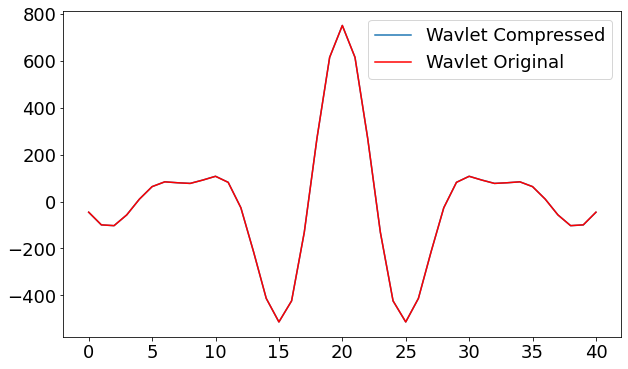

In [5]:
def std(x):
    x = x - np.mean(x)
    return x/np.std(x)

def crop(x, delta):
    N = len(x)
    return x[N//2-delta:N//2+delta+1]

def stat_wav(tracs):
    # standarize so stuff has the same range of values
    return crop(np.correlate(std(tracs), std(tracs), mode='full'), 20)

plt.figure(figsize=(10,6))
tracs = seismic_data['inline'][100,:,10]
wavelet = stat_wav(tracs)
plt.plot(wavelet)
#
tracs = seismic_data['inline_float'][100,:,10]
wavelet_compr = stat_wav(tracs)
plt.plot(wavelet_compr, '-r')
#
plt.legend(["Wavlet Compressed", 
            "Wavlet Original"])
plt.show()

### Try to guess at the wavelet they used

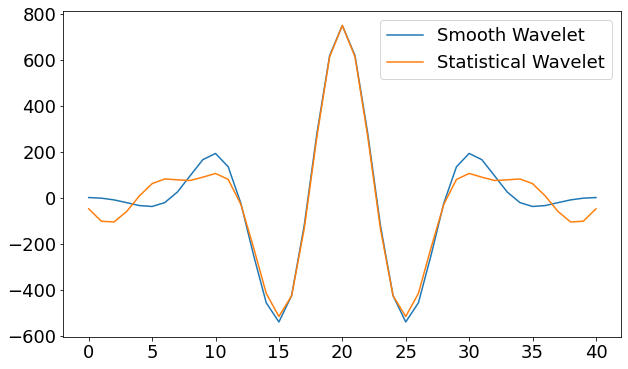

In [6]:
from scipy.optimize import minimize
def func(scale, wavelet):
    mor = morlet(len(wavelet), 3.5, scale).real
    mor *= np.max(wavelet)/mor.max()
    return (np.linalg.norm(mor - wavelet)**2)

# Guess a parameteric wavelet
result = minimize(func, np.array([0.5]), bounds=[(0,1)], args=[wavelet])

# adjust normalization 
smooth_wavelet = morlet(len(wavelet), 3.7, result.x).real
smooth_wavelet *= np.max(wavelet)/smooth_wavelet.max()
smooth_wavelet = smooth_wavelet[:,0]

plt.figure(figsize=(10,6))
plt.plot(smooth_wavelet)
plt.plot(wavelet)
plt.legend(["Smooth Wavelet", "Statistical Wavelet"])
plt.show()

In [7]:
# the original synthetic
seis = seismic_data['inline_float'][...,10]
# Ichthys data and a statistical wavelet
real_tracs = std(real_data['inline'][::20,:,2300])
# flatten the line and compute the acf everywhere to build statistics
real_stat_wavelet = stat_wav(real_tracs.ravel())

Plot the real statistical wavelet and mess around with the phase.

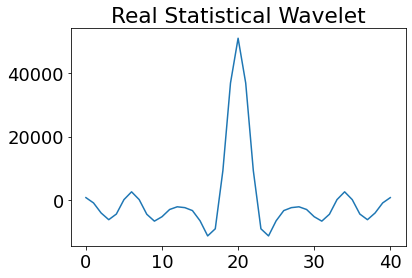

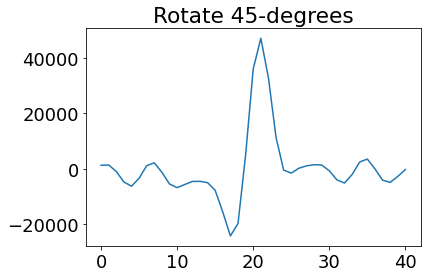

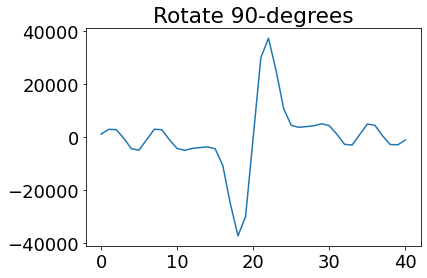

In [8]:
# phase rotate using hilbert transform, it's its own inverse
def apply_phase(x, phase):
    # phase should be (-pi,pi)
    return hilbert((hilbert(x)*np.exp(-phase * 1j)).real).real

plt.figure()
plt.plot(real_stat_wavelet)
plt.title("Real Statistical Wavelet")
plt.show()

plt.figure()
plt.plot(apply_phase(real_stat_wavelet, np.pi/4))
plt.title("Rotate 45-degrees")
plt.show()

plt.figure()
plt.plot(apply_phase(real_stat_wavelet, np.pi/2))
plt.title("Rotate 90-degrees")
plt.show()


Use a spike-convolutional model to get new versions of the synthetic data

In [9]:
def spike_conv_model(ai, seis, wavelet):
    # acoustics waves are reflected by an impedance contrast
    dai = gaussian_filter(std(ai), sigma=(0,1), order=1)

    synth = np.zeros(ai.shape)
    for i in range(ai.shape[0]):
        synth[i,:] = np.convolve(dai[i,:], wavelet, mode='same')
    synth *= seis.std()/synth.std()

    return synth

# spike conv model
synth = spike_conv_model(std(ai_data['inline'][:,:,10]), seis, smooth_wavelet)

# sharper spike conv model
sharp_synth = spike_conv_model(std(ai_data['inline'][:,:,10]), seis, real_stat_wavelet)


It's very likely that the synthetics are found by forward modeling, i.e. solving the acoustic wave equation. Compare our "smooth wavelet" spike convolution model to the original synthetic, compare what the synthetic would look like if we use the statistical wavelet from the real Ichthys3D data and compare with a section from the Ichthys3D.

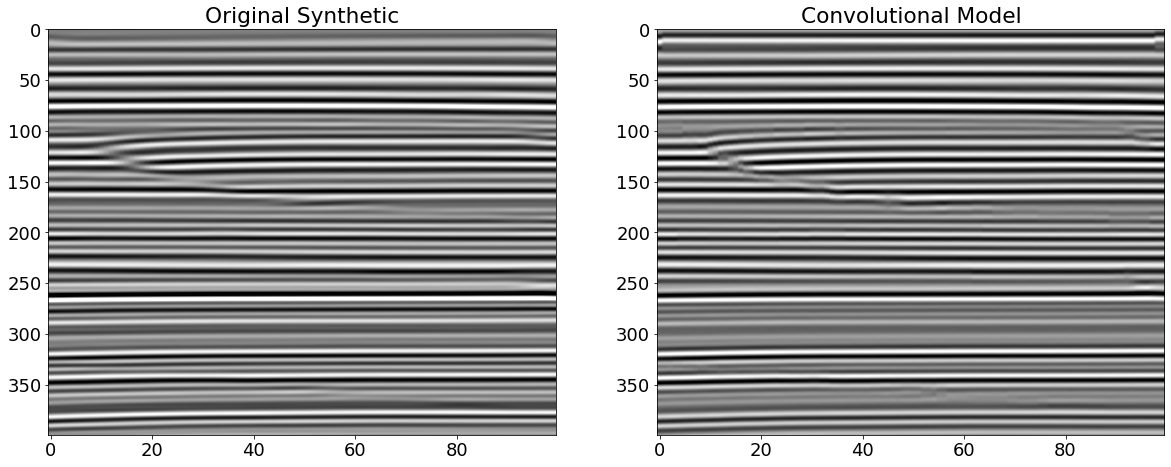

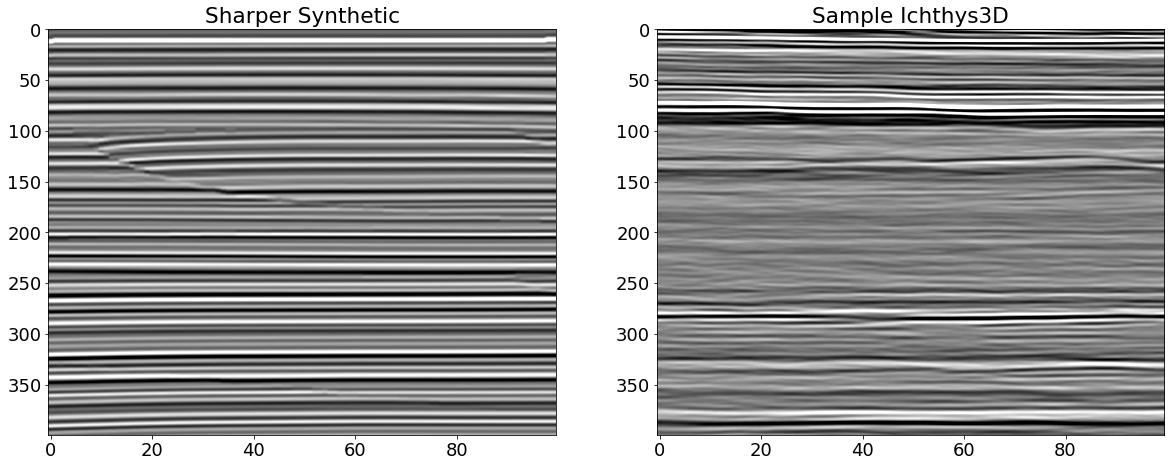

In [10]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(std(seis[100:200,:400]).T, cmap='gray', aspect=0.2, vmin=-2, vmax=2)
ax.set_title("Original Synthetic")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(std(synth[100:200,:400]).T, cmap='gray', aspect=0.2, vmin=-2, vmax=2)
ax.set_title("Convolutional Model")
plt.show()

real_tracs = std(real_data['inline'][100:200,:400,2300])

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(std(sharp_synth[100:200,:400]).T, cmap='gray', aspect=0.2, vmin=-2, vmax=2)
ax.set_title("Sharper Synthetic")

ax = fig.add_subplot(1, 2, 2)
plt.imshow(std(real_tracs).T, cmap='gray', aspect=0.2, vmin=-2, vmax=2)
ax.set_title("Sample Ichthys3D")

plt.show()


### Compare bandwidth
Realistically below -20Db is noise.

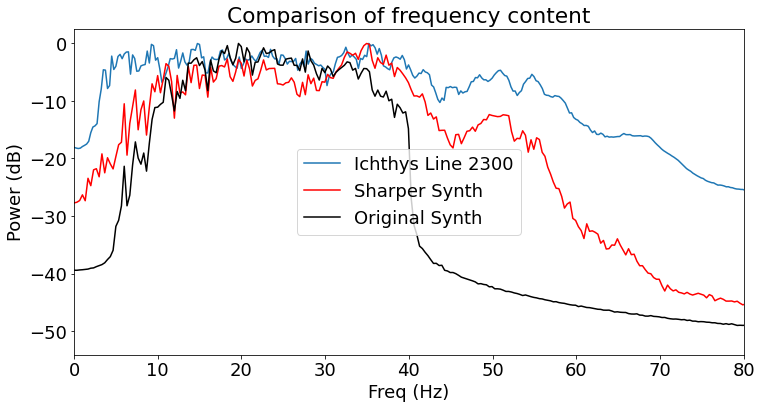

In [11]:
# Ichthys/Synthetics are 4ms sample rate according to binary header:
freqs_synth = np.fft.fftshift(np.fft.fftfreq(751, 0.004))
freqs_real = np.fft.fftshift(np.fft.fftfreq(1001, 0.004))

# I'm going to compute the power spectrum and average over the line
real_tracs = std(real_data['inline'][...,2300])
x = np.zeros(1001)
for i in np.arange(1001):
    x += np.fft.fftshift(np.abs(np.fft.fft(real_tracs[i,:])))
x /= x.max()

y = np.zeros(751)
for i in np.arange(589):
    y += np.fft.fftshift(np.abs(np.fft.fft(sharp_synth[i,:])))
y /= y.max()
    
z = np.zeros(751)
for i in np.arange(589):
    z += np.fft.fftshift(np.abs(np.fft.fft(seis[i,:])))
z /= z.max()
   
plt.figure(figsize=(12,6))
plt.plot(freqs_real[len(x)//2:], 20*np.log10(x[len(x)//2:]))
plt.plot(freqs_synth[len(y)//2:], 20*np.log10(y[len(y)//2:]), '-r')
plt.plot(freqs_synth[len(z)//2:], 20*np.log10(z[len(z)//2:]), '-k')
plt.legend(["Ichthys Line 2300", "Sharper Synth", "Original Synth"])
plt.xlabel("Freq (Hz)")
plt.ylabel("Power (dB)")
plt.title("Comparison of frequency content")
plt.xlim([0,80])
plt.show()

### Compare reflectivity synth/real

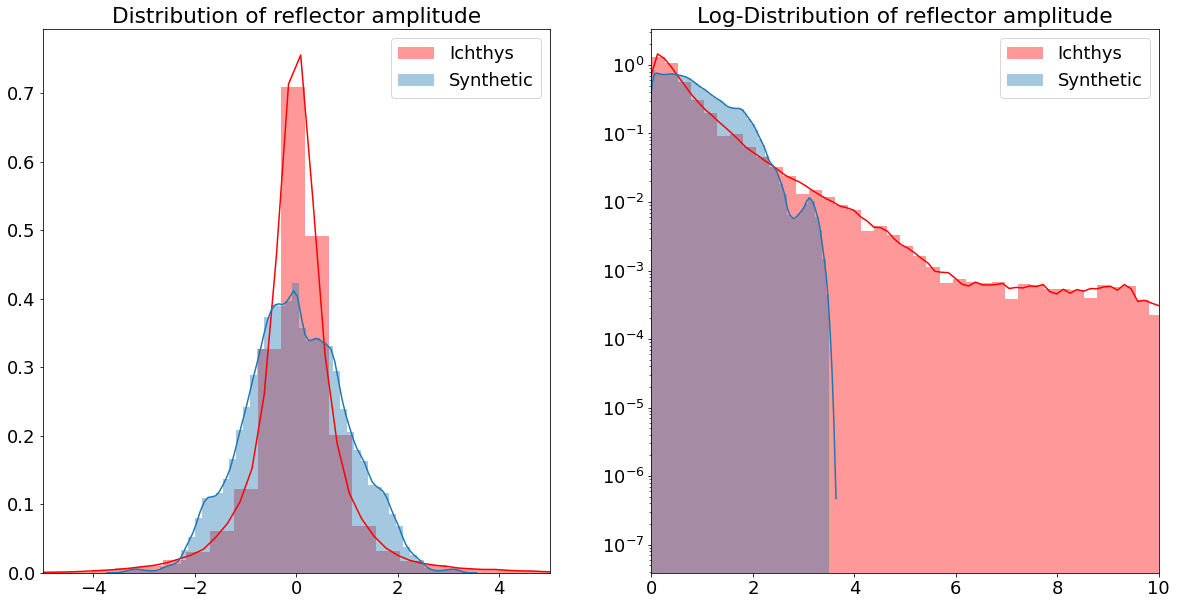

In [12]:
import seaborn as sns

# the original synthetic
seis = seismic_data['inline_float'][...,10]
# spike conv model
real_tracs = std(real_data['inline'][...,2300])


fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1, 2, 1)
sns.distplot(std(real_tracs.ravel()), color='red', ax=ax)
sns.distplot(std(seis.ravel()), ax=ax)
ax.set_title("Distribution of reflector amplitude")
ax.legend(["Ichthys", "Synthetic"])
ax.set_xlim([-5,5])


ax = fig.add_subplot(1, 2, 2)
sns.distplot(np.abs(std(real_tracs.ravel())), color='red', ax=ax)
sns.distplot(np.abs(std(seis.ravel())), ax=ax)
ax.set_xlim([0,10])
ax.set_title("Log-Distribution of reflector amplitude")
ax.set_yscale('log')
ax.legend(["Ichthys", "Synthetic"])
plt.show()